#Predicting Bitcoin Price

##Data Analysis

Use the exported data from 'Data Collection and Exploration' notebook to create a model for predicting the next day market price of bitcoin.

###Imports

In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import random
from sklearn.linear_model import LinearRegression
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

###Data Munging

Create the outcome variable `next_day`.

In [3]:
data = pd.read_csv('bitcoin_price.csv', index_col='trading_day')

next_day = data['price_usd'].iloc[1:]
data = data.iloc[:-1,:]
data['next_day'] = next_day.values
print data.shape

(2564, 32)


Create features for moving averages for price_usd.

In [4]:
data['ma_price_3'] = pd.rolling_mean(data['price_usd'], 3)
data['ma_price_7'] = pd.rolling_mean(data['price_usd'], 7)

print data.shape

(2564, 34)


Read in the Google Trends result and merge with the main data set.

In [6]:
def merge_columns(main, other):
    result = pd.merge(left=main,right=other, how='outer', left_on='date', right_on='date')
    
    return result


trends = pd.read_csv('bitcoin_trends.csv')
data = merge_columns(data, trends)

Select data subset of interest. Early timepoints with very low or sparse data are excluded from analysis.

In [7]:
data = data[(data.date >= '2011-01-01') & (data.date <= '2015-12-31')]
data = data.dropna()


In [8]:
print data.corr().head()

                    Unnamed: 0  block_size  block_transactions  \
Unnamed: 0            1.000000    0.908132            0.909417   
block_size            0.908132    1.000000            0.934314   
block_transactions    0.909417    0.934314            1.000000   
blockchain_size       0.932367    0.951699            0.943044   
transaction_cost      0.284348    0.083933            0.089623   

                    blockchain_size  transaction_cost  percent_cost  \
Unnamed: 0                 0.932367          0.284348     -0.536200   
block_size                 0.951699          0.083933     -0.426983   
block_transactions         0.943044          0.089623     -0.439828   
blockchain_size            1.000000          0.147301     -0.376637   
transaction_cost           0.147301          1.000000     -0.056436   

                    difficulty  transaction_vol  hash_rate  market_cap  \
Unnamed: 0            0.820410         0.014038   0.814306    0.690502   
block_size            0.9047

###Correlations

High correlations (>0.8) were identified between the ff. independent variables: 

- Group 1: block_size, block_transactions, blockchain_size, difficulty, hash_rate, all_transactions, sub10000_transactions, sub10_transactions, sub10_transactions, sub100_transactions, sub1000_transactions, short_transactions, nonpopular_transactions, unique_addresses, and total_transactions

- Group 2: transaction_cost, price_usd, miners_revenue, deficit, and market_cap

Low correlations (<0.4) were identified between the outcome `next_day` and the ff. independent variables:

- transaction_volume, percent_cost, confirmation_time, orphaned_blocks, transaction_fees, output_volume, trade_transaction_ratio,

  

In [9]:
columns_to_include = ['price_usd', 'exchange_vol_usd', 'blockchain_size',  
                      'total_bitcoins', 'total_transactions', 'bitcoin', 'ma_price_7', 
                      'ma_price_3', 'transaction_fees_usd', 'next_day']
selected_columns = list(set(columns_to_include) - set(['Unnamed: 0']))

df = data[selected_columns]

print df.head()

     total_transactions  next_day  price_usd  exchange_vol_usd  \
729              219086  0.299998   0.299996        706.308482   
730              219939  0.299899   0.299998       1082.671182   
731              221181  0.298998   0.299899        789.544097   
732              222373  0.299000   0.298998         57.813954   
733              223223  0.322000   0.299000        890.419309   

     blockchain_size  bitcoin  ma_price_7  transaction_fees_usd  ma_price_3  \
729               10        0    0.292285              0.027387    0.299998   
730               10        0    0.297284              0.208915    0.299997   
731               10        0    0.300127              0.023855    0.299964   
732               10        0    0.299841              0.017457    0.299632   
733               10        0    0.299698              0.026185    0.299299   

     total_bitcoins  
729         5036250  
730         5044450  
731         5051550  
732         5059050  
733         506640

### Ordinary Least-Squares Regression Model

In [188]:
lm = smf.ols('next_day ~ exchange_vol_usd + blockchain_size + total_bitcoins + total_transactions  + bitcoin + ma_price_7 + ma_price_3  +  price_usd + transaction_fees_usd', data=df)
fit = lm.fit()
print fit.summary()

                            OLS Regression Results                            
Dep. Variable:               next_day   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 4.368e+04
Date:                Sun, 10 Jan 2016   Prob (F-statistic):               0.00
Time:                        21:52:41   Log-Likelihood:                -7616.7
No. Observations:                1825   AIC:                         1.525e+04
Df Residuals:                    1815   BIC:                         1.531e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------
Intercept                4.7213 

Next step is to look at the P-values of each feature to determine suitability for inclusion in further analysis. The variables exchange_vol_usd and transaction_fees_usd have high P values and may be removed to simplify the model. In addition, a large condition number suggests strong multicollinearity which may be related to due the direct relationships among blockchain_size, total_bitcoins and total_transactions, so they will be excluded from the simplified model. 

In [41]:
lm2 = smf.ols('next_day ~ bitcoin +  ma_price_3  + ma_price_7 +  price_usd', data=df)
fit = lm2.fit()
print fit.summary()

                            OLS Regression Results                            
Dep. Variable:               next_day   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 9.795e+04
Date:                Mon, 11 Jan 2016   Prob (F-statistic):               0.00
Time:                        18:06:50   Log-Likelihood:                -7622.3
No. Observations:                1825   AIC:                         1.525e+04
Df Residuals:                    1820   BIC:                         1.528e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      0.2109      0.521      0.405      0.6

Use statsmodels to plot the residuals.

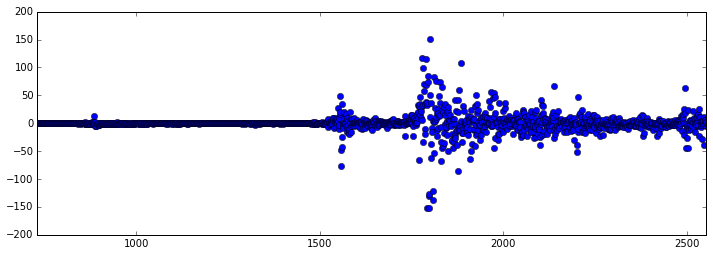

In [42]:
fit.resid.plot(style='o', figsize=(12,4))

###Linear Regression Analysis

Split the data into training and test set.

In [10]:
np.random.seed(1)
random.seed(1)
data = data.loc[np.random.permutation(data.index)]

# Select 70% of the dataset to be training data
highest_train_row = int(data.shape[0] * .7)
train = data.loc[:highest_train_row,:]

# Select 30% of the dataset to be test data.
test = data.loc[highest_train_row:,:]


Define the method to generate a regression model.

In [23]:
def regression_model(predictor):
    regressor= LinearRegression()

    regressor.fit(train[predictor], train['next_day'])
    predictions = regressor.predict(test[predictor])
    mse = sum((predictions - test['next_day']) ** 2) / len(predictions)
    score = regressor.score(test[predictor], test['next_day'])
    
    return regressor, predictions, mse, score

Define the method to visualize the model statistics. Make scatterplots with the actual values in the training set and test set.

In [30]:
def draw_scatterplot(predictor, regressor, predictions):
    plt.scatter(test[predictor], test['next_day'])
    plt.plot(test[predictor], predictions)
    plt.show()


Try out different models parameters.

In [35]:
rm , predictions, mse, score = regression_model(['exchange_vol_usd'])
print 'MSE: ', mse
print 'Score: ', score

rm , predictions, mse, score = regression_model(['blockchain_size'])
print 'MSE: ', mse
print 'Score: ', score

rm , predictions, mse, score = regression_model(['ma_price_3'])
print 'MSE: ', mse
print 'Score: ', score

rm , predictions, mse, score = regression_model(['bitcoin'])
print 'MSE: ', mse
print 'Score: ', score



MSE:  37315.9709651
Score:  0.315390894169
MSE:  40211.2924996
Score:  0.262272525933
MSE:  518.403449511
Score:  0.99048922719
MSE:  33454.0316692
Score:  0.386243098728


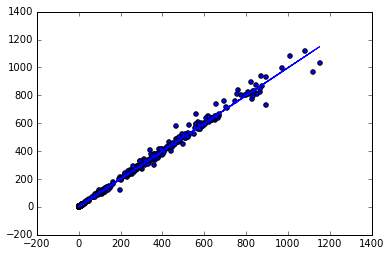

MSE:  272.995825119
Score:  0.994991543221
MSE:  273.863778152
Score:  0.994975619515
MSE:  273.742528387
Score:  0.994977843997


In [31]:
rm , predictions, mse, score = regression_model(['price_usd'])
draw_scatterplot('price_usd', rm, predictions)
print 'MSE: ', mse
print 'Score: ', score

rm, predictions, mse, score = regression_model(['price_usd', 'ma_price_3'])
print 'MSE: ', mse
print 'Score: ', score

rm, predictions, mse, score = regression_model(['price_usd', 'ma_price_3', 'ma_price_7'])
print 'MSE: ', mse
print 'Score: ', score

MSE:  272.789578809
Score:  0.994995327073


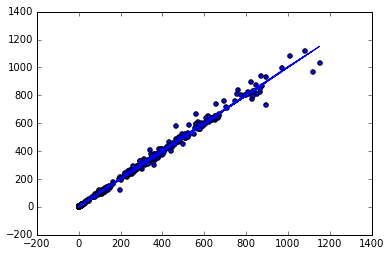

MSE:  274.670144477
Score:  0.994960825696
MSE:  274.68609664
Score:  0.994960533033


In [32]:
rm, predictions, mse, score = regression_model(['price_usd', 'total_transactions'])
print 'MSE: ', mse
print 'Score: ', score

rm, predictions, mse, score = regression_model(['price_usd', 'transaction_fees_usd'])
draw_scatterplot('price_usd', rm, predictions)
print 'MSE: ', mse
print 'Score: ', score

rm, predictions, mse, score = regression_model(['price_usd', 'transaction_fees_usd', 'total_bitcoins'])
print 'MSE: ', mse
print 'Score: ', score

###TODO: Autoregressive Modeling